# 生成提交文件(json文件)
- 注意：该处是用eval生成的，paddledetection配置文件中读取验证集需要先读取img和标注（这里把img路径改成测试集的，标注随便弄个json文件，将save_prediction_only=True）

In [8]:
#生成个test标注文件（无效的）
import os, sys, zipfile
import urllib.request
import shutil
import numpy as np
import skimage.io as io
import pandas
import matplotlib.pyplot as plt
import pylab
import json
import tqdm
from PIL import Image
#generate test 
def test_from_dir(pic_path): 
    pics = os.listdir(pic_path) 
    meta = {} 
    images = [] 
    annotations =  [        {
            "area": 326.1354999999996,
            "iscrowd": 0,
            "image_id": 449,
            "bbox": [
                1654.76,
                2975,
                22,
                15
            ],
            "category_id": 5,
            "ignore": 0,
            "segmentation": [],

            "id": 516
        }
        ] 
    categories=[]
    for v in range(1,7):
        print(v)
        category = {}
        category['id'] = v
        category['name'] = str(v)
        category['supercategory'] = 'defect_name'
        categories.append(category)
    num = 0 
    for im in pics: 
        num += 1 
        img = os.path.join(pic_path,im)
        img = Image.open(img)
        images_anno = {} 
        images_anno['file_name'] = im
        images_anno['width'] = img.size[0]
        images_anno['height'] = img.size[1]
        images_anno['id'] = num
        images.append(images_anno) 
    meta['images'] = images
    meta['categories'] = categories 
    meta['annotations'] = annotations
    json.dump(meta,open('../dataset/coco/annotations/instances_test.json','w'),indent=4, ensure_ascii=False) 

In [9]:
#生成测试集标注（伪标注，无效的）
pic_path='../dataset/coco/tile_round1_testA_20201231/testA_imgs'
test_from_dir(pic_path)

1
2
3
4
5
6


In [23]:
%cd /mnt/SDD1/docker_env/fabric/PaddleDetection/
!python tools/eval.py \
    -c configs/yuan/cascade_rcnn_r50_fpn_1x_test.yml \
    -o weights=/mnt/SDD1/docker_env/fabric/notebooks/train_models/cascade_rcnn_r50_paddle_456/20000.pdparams \
    save_prediction_only=True

/mnt/SDD1/docker_env/fabric/PaddleDetection
/mnt/SDD1/docker_env/fabric/PaddleDetection/ppdet/core/workspace.py:118: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  isinstance(merge_dct[k], collections.Mapping)):
/home/psdz/anaconda3/envs/paddle/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:297: UserWarning: /mnt/SDD1/docker_env/fabric/PaddleDetection/ppdet/modeling/backbones/fpn.py:108
The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_add(X, Y, axis=0) instead of A + B. This transitional warning will be dropped in the future.
  op_type, op_type, EXPRESSION_MAP[method_name]))
/home/psdz/anaconda3/envs/paddle/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:297: UserWarning: /mnt/SDD1/doc

In [21]:
#将评估预测的结果按照我们生成的测试集伪标注格式保存
bbox = '/mnt/SDD1/docker_env/fabric/PaddleDetection/bbox.json'
test_path = '/mnt/SDD1/docker_env/fabric/PaddleDetection/dataset/coco/annotations/instances_test.json'
sub_path = '/mnt/SDD1/docker_env/fabric/PaddleDetection/results.json'
def make_submittion(sub_path,bbox,test_path): 
    meta = {}
    with open(bbox) as f:
        bbox = json.load(f)
    with open(test_path) as f:
        test_ann = json.load(f)
    meta['images'] = test_ann['images']
    meta['annotations'] = bbox
    json.dump(meta,open(sub_path,'w'),indent=4) 
make_submittion(sub_path,bbox,test_path)

In [27]:
final_path = '/mnt/SDD1/docker_env/fabric/PaddleDetection/final_results.json'
results_path = '/mnt/SDD1/docker_env/fabric/PaddleDetection/results.json'
def final_result(final_path, results_path): 
    with open(results_path,"r") as f:
        test_result = json.load(f)
    #获取图片id对应的图片名字字典
    imgs = test_result["images"]
    dict_img = {}
    for img in imgs:
        img_name = img["file_name"]
        img_id = img["id"]
        dict_img[str(img_id)] = img_name
    #print(dict_img["1"])
    #按照提交格式对应字段
    final_results = []
    annotations = test_result["annotations"]
    for ann in annotations:
        dict_ann = {}
        #设置图片name
        #将图片id对应为name
        ann_name_id = str(ann["image_id"])
        dict_ann["name"] = dict_img[ann_name_id]
        #设置类别category
        dict_ann["category"] = ann["category_id"]
        #设置bbox
        #之前预测的bbox中格式为【左上角横坐标x，左上角纵坐标y，框的高h，框的宽w】
        #提交格式要求的bbox格式为【左上角横坐标，左上角纵坐标，右下角横坐标，右下角纵坐标】
        bbox = ann["bbox"]
        bbox = [bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]]
        dict_ann["bbox"] = bbox
        #设置置信度score
        dict_ann["score"] = ann["score"]
        if ann['score'] < 0.3: continue
        final_results.append(dict_ann)
        
    #print(final_results[0])
    json.dump(final_results,open(final_path,'w'),indent=4) 
final_result(final_path, results_path)

In [24]:
ann["score"]

NameError: name 'ann' is not defined

# paddle inference

In [1]:
import os 
import json
import numpy as np

## init

In [2]:

import os, sys
sys.path.insert(0, '../PaddleDetection')
import glob
import numpy as np
import six
from PIL import Image, ImageOps

import paddle
from paddle import fluid

from ppdet.core.workspace import load_config, merge_config, create

from ppdet.utils.eval_utils import parse_fetches
from ppdet.utils.cli import ArgsParser
from ppdet.utils.check import check_gpu, check_version, check_config, enable_static_mode
from ppdet.utils.visualizer import visualize_results
import ppdet.utils.checkpoint as checkpoint

from ppdet.data.reader import create_reader

import logging
FORMAT = '%(asctime)s-%(levelname)s: %(message)s'
logging.basicConfig(level=logging.INFO, format=FORMAT)
logger = logging.getLogger(__name__)


def get_save_image_name(output_dir, image_path):
    """
    Get save image name from source image path.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    image_name = os.path.split(image_path)[-1]
    name, ext = os.path.splitext(image_name)
    return os.path.join(output_dir, "{}".format(name)) + ext


def get_test_images(infer_dir, infer_img):
    """
    Get image path list in TEST mode
    """
    assert infer_img is not None or infer_dir is not None, \
        "--infer_img or --infer_dir should be set"
    assert infer_img is None or os.path.isfile(infer_img), \
            "{} is not a file".format(infer_img)
    assert infer_dir is None or os.path.isdir(infer_dir), \
            "{} is not a directory".format(infer_dir)

    # infer_img has a higher priority
    if infer_img and os.path.isfile(infer_img):
        return [infer_img]

    images = set()
    infer_dir = os.path.abspath(infer_dir)
    assert os.path.isdir(infer_dir), \
        "infer_dir {} is not a directory".format(infer_dir)
    exts = ['jpg', 'jpeg', 'png', 'bmp']
    exts += [ext.upper() for ext in exts]
    for ext in exts:
        images.update(glob.glob('{}/*.{}'.format(infer_dir, ext)))
    images = list(images)

    assert len(images) > 0, "no image found in {}".format(infer_dir)
    logger.info("Found {} inference images in total.".format(len(images)))

    return images


   


In [3]:
enable_static_mode()
parser = ArgsParser()
parser.add_argument(
    "--infer_dir",
    type=str,
    default=None,
    help="Directory for images to perform inference on.")
parser.add_argument(
    "--infer_img",
    type=str,
    default=None,
    help="Image path, has higher priority over --infer_dir")
parser.add_argument(
    "--output_dir",
    type=str,
    default="output",
    help="Directory for storing the output visualization files.")
parser.add_argument(
    "--draw_threshold",
    type=float,
    default=0.5,
    help="Threshold to reserve the result for visualization.")
parser.add_argument(
    "--use_vdl",
    type=bool,
    default=False,
    help="whether to record the data to VisualDL.")
parser.add_argument(
    '--vdl_log_dir',
    type=str,
    default="vdl_log_dir/image",
    help='VisualDL logging directory for image.')

FLAGS = parser.parse_args(['-c=/mnt/SDD1/docker_env/fabric/PaddleDetection/configs/yuan/cascade_rcnn_r50_fpn_1x_test.yml', 
                          '--infer_dir=/mnt/SDD1/docker_env/fabric/dataset/coco2/test_clean'])

In [4]:
pwd

'/mnt/SDD1/docker_env/fabric/notebooks'

## modify config

In [5]:
enable_static_mode()

cfg = load_config(FLAGS.config)

merge_config(FLAGS.opt)
check_config(cfg)
# check if set use_gpu=True in paddlepaddle cpu version
check_gpu(cfg.use_gpu)
# check if paddlepaddle version is satisfied
check_version()

../PaddleDetection/ppdet/core/workspace.py:118: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  isinstance(merge_dct[k], collections.Mapping)):


In [6]:
cfg['weights'] = '/mnt/SDD1/docker_env/fabric/notebooks/train_models/cascade_rcnn_r50_paddle_1024_base/model_final'

## model init

In [7]:
main_arch = cfg.architecture

dataset = cfg.TestReader['dataset']

test_images = get_test_images(FLAGS.infer_dir, FLAGS.infer_img)
dataset.set_images(test_images)

place = fluid.CUDAPlace(0) if cfg.use_gpu else fluid.CPUPlace()
exe = fluid.Executor(place)

model = create(main_arch)

startup_prog = fluid.Program()
infer_prog = fluid.Program()
with fluid.program_guard(infer_prog, startup_prog):
    with fluid.unique_name.guard():
        inputs_def = cfg['TestReader']['inputs_def']
        inputs_def['iterable'] = True
        feed_vars, loader = model.build_inputs(**inputs_def)
        test_fetches = model.test(feed_vars)
infer_prog = infer_prog.clone(True)

reader = create_reader(cfg.TestReader, devices_num=1)
loader.set_sample_list_generator(reader, place)

exe.run(startup_prog)
if cfg.weights:
    checkpoint.load_params(exe, infer_prog, cfg.weights)

# parse infer fetches
assert cfg.metric in ['COCO', 'VOC', 'OID', 'WIDERFACE'], \
        "unknown metric type {}".format(cfg.metric)
extra_keys = []
if cfg['metric'] in ['COCO', 'OID']:
    extra_keys = ['im_info', 'im_id', 'im_shape']
if cfg['metric'] == 'VOC' or cfg['metric'] == 'WIDERFACE':
    extra_keys = ['im_id', 'im_shape']
keys, values, _ = parse_fetches(test_fetches, infer_prog, extra_keys)

# parse dataset category
if cfg.metric == 'COCO':
    from ppdet.utils.coco_eval import bbox2out, mask2out, segm2out, get_category_info
if cfg.metric == 'OID':
    from ppdet.utils.oid_eval import bbox2out, get_category_info
if cfg.metric == "VOC":
    from ppdet.utils.voc_eval import bbox2out, get_category_info
if cfg.metric == "WIDERFACE":
    from ppdet.utils.widerface_eval_utils import bbox2out, lmk2out, get_category_info

# anno_file = dataset.get_anno()
# with_background = dataset.with_background
# use_default_label = dataset.use_default_label

# clsid2catid, catid2name = get_category_info(anno_file, with_background,
#                                             use_default_label)
clsid2catid = {1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7}
catid2name = {0:'background', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6'}
# whether output bbox is normalized in model output layer
is_bbox_normalized = False
if hasattr(model, 'is_bbox_normalized') and \
        callable(model.is_bbox_normalized):
    is_bbox_normalized = model.is_bbox_normalized()


imid2path = dataset.get_imid2path()



2021-01-23 12:56:03,022-INFO: Found 188856 inference images in total.
/home/psdz/anaconda3/envs/paddle/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:297: UserWarning: ../PaddleDetection/ppdet/modeling/backbones/fpn.py:108
The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_add(X, Y, axis=0) instead of A + B. This transitional warning will be dropped in the future.
  op_type, op_type, EXPRESSION_MAP[method_name]))
/home/psdz/anaconda3/envs/paddle/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:297: UserWarning: ../PaddleDetection/ppdet/modeling/roi_heads/cascade_head.py:199
The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_add(X, Y, axis=0) instead of A + B

In [8]:
result_dict = {}
patch_size = 1024
patch_stride = 512
ori_img_dir = '/mnt/SDD1/docker_env/fabric/PaddleDetection/dataset/coco/tile_round1_testA_20201231/testA_imgs'
for iter_id, data in enumerate(loader()):
    outs = exe.run(infer_prog,
                   feed=data,
                   fetch_list=values,
                   return_numpy=False)
    res = {
        k: (np.array(v), v.recursive_sequence_lengths())
        for k, v in zip(keys, outs)
    }
    logger.info('Infer iter {}'.format(iter_id))

    bbox_results = None
    mask_results = None
    segm_results = None
    lmk_results = None
    if 'bbox' in res:
        bbox_results = bbox2out([res], clsid2catid, is_bbox_normalized)
    if 'mask' in res:
        mask_results = mask2out([res], clsid2catid,
                                model.mask_head.resolution)
    if 'segm' in res:
        segm_results = segm2out([res], clsid2catid)
    if 'landmark' in res:
        lmk_results = lmk2out([res], is_bbox_normalized)

    for bbox_result in bbox_results:
        patch_id = bbox_result['image_id']
        image_patch_path = imid2path[int(patch_id)]
        image_patch_name = os.path.basename(image_patch_path)
        ori_img_name = image_patch_name.split('-')[0] + '.jpg'
        
        # 图像块在原图起始坐标保存在图像块名字上
        patch_x, patch_y = os.path.splitext(image_patch_path)[0].split('-')[-1].split('_')
        patch_x, patch_y = int(patch_x), int(patch_y)
        if ori_img_name not in result_dict.keys():
            result_dict[ori_img_name] = {'boxes':[], 'scores':[], 'categories':[]}
        
        result_dict[ori_img_name]['scores'].append(bbox_result['score'])
        result_dict[ori_img_name]['categories'].append(bbox_result['category_id'])
        ori_img_name_path = os.path.join(ori_img_dir, ori_img_name)
        
        # 映射回原图
        x1, y1, w, h = bbox_result['bbox']
        x1 = x1 + patch_x
        y1 = y1 + patch_y
        x2 = x1 + w
        y2 = y1 + h
        result_dict[ori_img_name]['boxes'].append([x1, y1, x2, y2])

2021-01-23 12:56:10,953-INFO: Infer iter 0
2021-01-23 12:56:12,209-INFO: Infer iter 1
2021-01-23 12:56:13,538-INFO: Infer iter 2
2021-01-23 12:56:14,865-INFO: Infer iter 3
2021-01-23 12:56:16,106-INFO: Infer iter 4
2021-01-23 12:56:17,350-INFO: Infer iter 5
2021-01-23 12:56:18,591-INFO: Infer iter 6
2021-01-23 12:56:19,841-INFO: Infer iter 7
2021-01-23 12:56:21,084-INFO: Infer iter 8
2021-01-23 12:56:22,331-INFO: Infer iter 9
2021-01-23 12:56:23,579-INFO: Infer iter 10
2021-01-23 12:56:24,824-INFO: Infer iter 11
2021-01-23 12:56:26,073-INFO: Infer iter 12
2021-01-23 12:56:27,325-INFO: Infer iter 13
2021-01-23 12:56:28,577-INFO: Infer iter 14
2021-01-23 12:56:29,826-INFO: Infer iter 15
2021-01-23 12:56:31,101-INFO: Infer iter 16
2021-01-23 12:56:32,410-INFO: Infer iter 17
2021-01-23 12:56:33,698-INFO: Infer iter 18
2021-01-23 12:56:34,950-INFO: Infer iter 19
2021-01-23 12:56:36,204-INFO: Infer iter 20
2021-01-23 12:56:37,459-INFO: Infer iter 21
2021-01-23 12:56:38,713-INFO: Infer iter 2

2021-01-23 13:00:02,330-INFO: Infer iter 185
2021-01-23 13:00:03,580-INFO: Infer iter 186
2021-01-23 13:00:04,822-INFO: Infer iter 187
2021-01-23 13:00:06,068-INFO: Infer iter 188
2021-01-23 13:00:07,310-INFO: Infer iter 189
2021-01-23 13:00:08,555-INFO: Infer iter 190
2021-01-23 13:00:09,797-INFO: Infer iter 191
2021-01-23 13:00:11,040-INFO: Infer iter 192
2021-01-23 13:00:12,281-INFO: Infer iter 193
2021-01-23 13:00:13,528-INFO: Infer iter 194
2021-01-23 13:00:14,769-INFO: Infer iter 195
2021-01-23 13:00:16,009-INFO: Infer iter 196
2021-01-23 13:00:17,253-INFO: Infer iter 197
2021-01-23 13:00:18,495-INFO: Infer iter 198
2021-01-23 13:00:19,737-INFO: Infer iter 199
2021-01-23 13:00:20,979-INFO: Infer iter 200
2021-01-23 13:00:22,219-INFO: Infer iter 201
2021-01-23 13:00:23,462-INFO: Infer iter 202
2021-01-23 13:00:24,703-INFO: Infer iter 203
2021-01-23 13:00:25,945-INFO: Infer iter 204
2021-01-23 13:00:27,185-INFO: Infer iter 205
2021-01-23 13:00:28,429-INFO: Infer iter 206
2021-01-23

2021-01-23 13:03:49,943-INFO: Infer iter 368
2021-01-23 13:03:51,183-INFO: Infer iter 369
2021-01-23 13:03:52,425-INFO: Infer iter 370
2021-01-23 13:03:53,672-INFO: Infer iter 371
2021-01-23 13:03:54,914-INFO: Infer iter 372
2021-01-23 13:03:56,158-INFO: Infer iter 373
2021-01-23 13:03:57,406-INFO: Infer iter 374
2021-01-23 13:03:58,651-INFO: Infer iter 375
2021-01-23 13:03:59,892-INFO: Infer iter 376
2021-01-23 13:04:01,136-INFO: Infer iter 377
2021-01-23 13:04:02,379-INFO: Infer iter 378
2021-01-23 13:04:03,622-INFO: Infer iter 379
2021-01-23 13:04:04,867-INFO: Infer iter 380
2021-01-23 13:04:06,109-INFO: Infer iter 381
2021-01-23 13:04:07,352-INFO: Infer iter 382
2021-01-23 13:04:08,594-INFO: Infer iter 383
2021-01-23 13:04:09,840-INFO: Infer iter 384
2021-01-23 13:04:11,082-INFO: Infer iter 385
2021-01-23 13:04:12,325-INFO: Infer iter 386
2021-01-23 13:04:13,573-INFO: Infer iter 387
2021-01-23 13:04:14,819-INFO: Infer iter 388
2021-01-23 13:04:16,065-INFO: Infer iter 389
2021-01-23

2021-01-23 13:07:37,706-INFO: Infer iter 551
2021-01-23 13:07:38,949-INFO: Infer iter 552
2021-01-23 13:07:40,189-INFO: Infer iter 553
2021-01-23 13:07:41,434-INFO: Infer iter 554
2021-01-23 13:07:42,678-INFO: Infer iter 555
2021-01-23 13:07:43,919-INFO: Infer iter 556
2021-01-23 13:07:45,165-INFO: Infer iter 557
2021-01-23 13:07:46,408-INFO: Infer iter 558
2021-01-23 13:07:47,655-INFO: Infer iter 559
2021-01-23 13:07:48,898-INFO: Infer iter 560
2021-01-23 13:07:50,144-INFO: Infer iter 561
2021-01-23 13:07:51,389-INFO: Infer iter 562
2021-01-23 13:07:52,636-INFO: Infer iter 563
2021-01-23 13:07:53,879-INFO: Infer iter 564
2021-01-23 13:07:55,125-INFO: Infer iter 565
2021-01-23 13:07:56,381-INFO: Infer iter 566
2021-01-23 13:07:57,623-INFO: Infer iter 567
2021-01-23 13:07:58,869-INFO: Infer iter 568
2021-01-23 13:08:00,113-INFO: Infer iter 569
2021-01-23 13:08:01,359-INFO: Infer iter 570
2021-01-23 13:08:02,603-INFO: Infer iter 571
2021-01-23 13:08:03,850-INFO: Infer iter 572
2021-01-23

2021-01-23 13:11:25,546-INFO: Infer iter 734
2021-01-23 13:11:26,789-INFO: Infer iter 735
2021-01-23 13:11:28,037-INFO: Infer iter 736
2021-01-23 13:11:29,280-INFO: Infer iter 737
2021-01-23 13:11:30,528-INFO: Infer iter 738
2021-01-23 13:11:31,774-INFO: Infer iter 739
2021-01-23 13:11:33,049-INFO: Infer iter 740
2021-01-23 13:11:34,292-INFO: Infer iter 741
2021-01-23 13:11:35,537-INFO: Infer iter 742
2021-01-23 13:11:36,781-INFO: Infer iter 743
2021-01-23 13:11:38,023-INFO: Infer iter 744
2021-01-23 13:11:39,268-INFO: Infer iter 745
2021-01-23 13:11:40,514-INFO: Infer iter 746
2021-01-23 13:11:41,758-INFO: Infer iter 747
2021-01-23 13:11:43,002-INFO: Infer iter 748
2021-01-23 13:11:44,246-INFO: Infer iter 749
2021-01-23 13:11:45,492-INFO: Infer iter 750
2021-01-23 13:11:46,739-INFO: Infer iter 751
2021-01-23 13:11:47,982-INFO: Infer iter 752
2021-01-23 13:11:49,227-INFO: Infer iter 753
2021-01-23 13:11:50,473-INFO: Infer iter 754
2021-01-23 13:11:51,719-INFO: Infer iter 755
2021-01-23

2021-01-23 13:15:13,445-INFO: Infer iter 917
2021-01-23 13:15:14,711-INFO: Infer iter 918
2021-01-23 13:15:15,958-INFO: Infer iter 919
2021-01-23 13:15:17,198-INFO: Infer iter 920
2021-01-23 13:15:18,443-INFO: Infer iter 921
2021-01-23 13:15:19,687-INFO: Infer iter 922
2021-01-23 13:15:20,937-INFO: Infer iter 923
2021-01-23 13:15:22,179-INFO: Infer iter 924
2021-01-23 13:15:23,427-INFO: Infer iter 925
2021-01-23 13:15:24,671-INFO: Infer iter 926
2021-01-23 13:15:25,920-INFO: Infer iter 927
2021-01-23 13:15:27,163-INFO: Infer iter 928
2021-01-23 13:15:28,405-INFO: Infer iter 929
2021-01-23 13:15:29,649-INFO: Infer iter 930
2021-01-23 13:15:30,889-INFO: Infer iter 931
2021-01-23 13:15:32,136-INFO: Infer iter 932
2021-01-23 13:15:33,383-INFO: Infer iter 933
2021-01-23 13:15:34,628-INFO: Infer iter 934
2021-01-23 13:15:35,871-INFO: Infer iter 935
2021-01-23 13:15:37,115-INFO: Infer iter 936
2021-01-23 13:15:38,358-INFO: Infer iter 937
2021-01-23 13:15:39,605-INFO: Infer iter 938
2021-01-23

2021-01-23 13:18:57,597-INFO: Infer iter 1097
2021-01-23 13:18:58,843-INFO: Infer iter 1098
2021-01-23 13:19:00,089-INFO: Infer iter 1099
2021-01-23 13:19:01,334-INFO: Infer iter 1100
2021-01-23 13:19:02,576-INFO: Infer iter 1101
2021-01-23 13:19:03,820-INFO: Infer iter 1102
2021-01-23 13:19:05,071-INFO: Infer iter 1103
2021-01-23 13:19:06,317-INFO: Infer iter 1104
2021-01-23 13:19:07,562-INFO: Infer iter 1105
2021-01-23 13:19:08,807-INFO: Infer iter 1106
2021-01-23 13:19:10,050-INFO: Infer iter 1107
2021-01-23 13:19:11,296-INFO: Infer iter 1108
2021-01-23 13:19:12,543-INFO: Infer iter 1109
2021-01-23 13:19:13,787-INFO: Infer iter 1110
2021-01-23 13:19:15,047-INFO: Infer iter 1111
2021-01-23 13:19:16,293-INFO: Infer iter 1112
2021-01-23 13:19:17,540-INFO: Infer iter 1113
2021-01-23 13:19:18,787-INFO: Infer iter 1114
2021-01-23 13:19:20,032-INFO: Infer iter 1115
2021-01-23 13:19:21,278-INFO: Infer iter 1116
2021-01-23 13:19:22,524-INFO: Infer iter 1117
2021-01-23 13:19:23,771-INFO: Infe

2021-01-23 13:22:40,595-INFO: Infer iter 1276
2021-01-23 13:22:41,859-INFO: Infer iter 1277
2021-01-23 13:22:43,100-INFO: Infer iter 1278
2021-01-23 13:22:44,347-INFO: Infer iter 1279
2021-01-23 13:22:45,592-INFO: Infer iter 1280
2021-01-23 13:22:46,834-INFO: Infer iter 1281
2021-01-23 13:22:48,078-INFO: Infer iter 1282
2021-01-23 13:22:49,322-INFO: Infer iter 1283
2021-01-23 13:22:50,570-INFO: Infer iter 1284
2021-01-23 13:22:51,811-INFO: Infer iter 1285
2021-01-23 13:22:53,058-INFO: Infer iter 1286
2021-01-23 13:22:54,304-INFO: Infer iter 1287
2021-01-23 13:22:55,553-INFO: Infer iter 1288
2021-01-23 13:22:56,796-INFO: Infer iter 1289
2021-01-23 13:22:58,040-INFO: Infer iter 1290
2021-01-23 13:22:59,285-INFO: Infer iter 1291
2021-01-23 13:23:00,534-INFO: Infer iter 1292
2021-01-23 13:23:01,778-INFO: Infer iter 1293
2021-01-23 13:23:03,025-INFO: Infer iter 1294
2021-01-23 13:23:04,272-INFO: Infer iter 1295
2021-01-23 13:23:05,526-INFO: Infer iter 1296
2021-01-23 13:23:06,768-INFO: Infe

2021-01-23 13:26:23,603-INFO: Infer iter 1455
2021-01-23 13:26:24,847-INFO: Infer iter 1456
2021-01-23 13:26:26,089-INFO: Infer iter 1457
2021-01-23 13:26:27,351-INFO: Infer iter 1458
2021-01-23 13:26:28,597-INFO: Infer iter 1459
2021-01-23 13:26:29,839-INFO: Infer iter 1460
2021-01-23 13:26:31,081-INFO: Infer iter 1461
2021-01-23 13:26:32,328-INFO: Infer iter 1462
2021-01-23 13:26:33,571-INFO: Infer iter 1463
2021-01-23 13:26:34,815-INFO: Infer iter 1464
2021-01-23 13:26:36,059-INFO: Infer iter 1465
2021-01-23 13:26:37,305-INFO: Infer iter 1466
2021-01-23 13:26:38,552-INFO: Infer iter 1467
2021-01-23 13:26:39,795-INFO: Infer iter 1468
2021-01-23 13:26:41,040-INFO: Infer iter 1469
2021-01-23 13:26:42,289-INFO: Infer iter 1470
2021-01-23 13:26:43,539-INFO: Infer iter 1471
2021-01-23 13:26:44,783-INFO: Infer iter 1472
2021-01-23 13:26:46,028-INFO: Infer iter 1473
2021-01-23 13:26:47,272-INFO: Infer iter 1474
2021-01-23 13:26:48,518-INFO: Infer iter 1475
2021-01-23 13:26:49,762-INFO: Infe

2021-01-23 13:30:06,607-INFO: Infer iter 1634
2021-01-23 13:30:07,850-INFO: Infer iter 1635
2021-01-23 13:30:09,095-INFO: Infer iter 1636
2021-01-23 13:30:10,346-INFO: Infer iter 1637
2021-01-23 13:30:11,591-INFO: Infer iter 1638
2021-01-23 13:30:12,837-INFO: Infer iter 1639
2021-01-23 13:30:14,083-INFO: Infer iter 1640
2021-01-23 13:30:15,336-INFO: Infer iter 1641
2021-01-23 13:30:16,579-INFO: Infer iter 1642
2021-01-23 13:30:17,840-INFO: Infer iter 1643
2021-01-23 13:30:19,105-INFO: Infer iter 1644
2021-01-23 13:30:20,350-INFO: Infer iter 1645
2021-01-23 13:30:21,595-INFO: Infer iter 1646
2021-01-23 13:30:22,840-INFO: Infer iter 1647
2021-01-23 13:30:24,086-INFO: Infer iter 1648
2021-01-23 13:30:25,330-INFO: Infer iter 1649
2021-01-23 13:30:26,576-INFO: Infer iter 1650
2021-01-23 13:30:27,820-INFO: Infer iter 1651
2021-01-23 13:30:29,066-INFO: Infer iter 1652
2021-01-23 13:30:30,311-INFO: Infer iter 1653
2021-01-23 13:30:31,555-INFO: Infer iter 1654
2021-01-23 13:30:32,801-INFO: Infe

2021-01-23 13:33:49,786-INFO: Infer iter 1813
2021-01-23 13:33:51,035-INFO: Infer iter 1814
2021-01-23 13:33:52,279-INFO: Infer iter 1815
2021-01-23 13:33:53,526-INFO: Infer iter 1816
2021-01-23 13:33:54,769-INFO: Infer iter 1817
2021-01-23 13:33:56,016-INFO: Infer iter 1818
2021-01-23 13:33:57,263-INFO: Infer iter 1819
2021-01-23 13:33:58,514-INFO: Infer iter 1820
2021-01-23 13:33:59,758-INFO: Infer iter 1821
2021-01-23 13:34:01,007-INFO: Infer iter 1822
2021-01-23 13:34:02,257-INFO: Infer iter 1823
2021-01-23 13:34:03,506-INFO: Infer iter 1824
2021-01-23 13:34:04,777-INFO: Infer iter 1825
2021-01-23 13:34:06,024-INFO: Infer iter 1826
2021-01-23 13:34:07,270-INFO: Infer iter 1827
2021-01-23 13:34:08,519-INFO: Infer iter 1828
2021-01-23 13:34:09,767-INFO: Infer iter 1829
2021-01-23 13:34:11,012-INFO: Infer iter 1830
2021-01-23 13:34:12,261-INFO: Infer iter 1831
2021-01-23 13:34:13,511-INFO: Infer iter 1832
2021-01-23 13:34:14,754-INFO: Infer iter 1833
2021-01-23 13:34:15,999-INFO: Infe

2021-01-23 13:37:33,083-INFO: Infer iter 1992
2021-01-23 13:37:34,331-INFO: Infer iter 1993
2021-01-23 13:37:35,579-INFO: Infer iter 1994
2021-01-23 13:37:36,828-INFO: Infer iter 1995
2021-01-23 13:37:38,070-INFO: Infer iter 1996
2021-01-23 13:37:39,317-INFO: Infer iter 1997
2021-01-23 13:37:40,564-INFO: Infer iter 1998
2021-01-23 13:37:41,811-INFO: Infer iter 1999
2021-01-23 13:37:43,056-INFO: Infer iter 2000
2021-01-23 13:37:44,302-INFO: Infer iter 2001
2021-01-23 13:37:45,548-INFO: Infer iter 2002
2021-01-23 13:37:46,796-INFO: Infer iter 2003
2021-01-23 13:37:48,046-INFO: Infer iter 2004
2021-01-23 13:37:49,291-INFO: Infer iter 2005
2021-01-23 13:37:50,539-INFO: Infer iter 2006
2021-01-23 13:37:51,785-INFO: Infer iter 2007
2021-01-23 13:37:53,034-INFO: Infer iter 2008
2021-01-23 13:37:54,283-INFO: Infer iter 2009
2021-01-23 13:37:55,556-INFO: Infer iter 2010
2021-01-23 13:37:56,801-INFO: Infer iter 2011
2021-01-23 13:37:58,050-INFO: Infer iter 2012
2021-01-23 13:37:59,296-INFO: Infe

2021-01-23 13:41:16,565-INFO: Infer iter 2171
2021-01-23 13:41:17,813-INFO: Infer iter 2172
2021-01-23 13:41:19,062-INFO: Infer iter 2173
2021-01-23 13:41:20,310-INFO: Infer iter 2174
2021-01-23 13:41:21,557-INFO: Infer iter 2175
2021-01-23 13:41:22,805-INFO: Infer iter 2176
2021-01-23 13:41:24,056-INFO: Infer iter 2177
2021-01-23 13:41:25,303-INFO: Infer iter 2178
2021-01-23 13:41:26,553-INFO: Infer iter 2179
2021-01-23 13:41:27,801-INFO: Infer iter 2180
2021-01-23 13:41:29,051-INFO: Infer iter 2181
2021-01-23 13:41:30,298-INFO: Infer iter 2182
2021-01-23 13:41:31,547-INFO: Infer iter 2183
2021-01-23 13:41:32,795-INFO: Infer iter 2184
2021-01-23 13:41:34,040-INFO: Infer iter 2185
2021-01-23 13:41:35,289-INFO: Infer iter 2186
2021-01-23 13:41:36,537-INFO: Infer iter 2187
2021-01-23 13:41:37,785-INFO: Infer iter 2188
2021-01-23 13:41:39,034-INFO: Infer iter 2189
2021-01-23 13:41:40,281-INFO: Infer iter 2190
2021-01-23 13:41:41,529-INFO: Infer iter 2191
2021-01-23 13:41:42,777-INFO: Infe

2021-01-23 13:45:00,057-INFO: Infer iter 2350
2021-01-23 13:45:01,305-INFO: Infer iter 2351
2021-01-23 13:45:02,553-INFO: Infer iter 2352
2021-01-23 13:45:03,802-INFO: Infer iter 2353
2021-01-23 13:45:05,050-INFO: Infer iter 2354
2021-01-23 13:45:06,295-INFO: Infer iter 2355
2021-01-23 13:45:07,546-INFO: Infer iter 2356
2021-01-23 13:45:08,797-INFO: Infer iter 2357
2021-01-23 13:45:10,043-INFO: Infer iter 2358
2021-01-23 13:45:11,291-INFO: Infer iter 2359
2021-01-23 13:45:12,539-INFO: Infer iter 2360
2021-01-23 13:45:13,788-INFO: Infer iter 2361
2021-01-23 13:45:15,038-INFO: Infer iter 2362
2021-01-23 13:45:16,284-INFO: Infer iter 2363
2021-01-23 13:45:17,533-INFO: Infer iter 2364
2021-01-23 13:45:18,779-INFO: Infer iter 2365
2021-01-23 13:45:20,027-INFO: Infer iter 2366
2021-01-23 13:45:21,278-INFO: Infer iter 2367
2021-01-23 13:45:22,524-INFO: Infer iter 2368
2021-01-23 13:45:23,770-INFO: Infer iter 2369
2021-01-23 13:45:25,018-INFO: Infer iter 2370
2021-01-23 13:45:26,267-INFO: Infe

2021-01-23 13:48:43,567-INFO: Infer iter 2529
2021-01-23 13:48:44,815-INFO: Infer iter 2530
2021-01-23 13:48:46,061-INFO: Infer iter 2531
2021-01-23 13:48:47,309-INFO: Infer iter 2532
2021-01-23 13:48:48,554-INFO: Infer iter 2533
2021-01-23 13:48:49,801-INFO: Infer iter 2534
2021-01-23 13:48:51,047-INFO: Infer iter 2535
2021-01-23 13:48:52,299-INFO: Infer iter 2536
2021-01-23 13:48:53,546-INFO: Infer iter 2537
2021-01-23 13:48:54,794-INFO: Infer iter 2538
2021-01-23 13:48:56,044-INFO: Infer iter 2539
2021-01-23 13:48:57,306-INFO: Infer iter 2540
2021-01-23 13:48:58,560-INFO: Infer iter 2541
2021-01-23 13:48:59,809-INFO: Infer iter 2542
2021-01-23 13:49:01,058-INFO: Infer iter 2543
2021-01-23 13:49:02,308-INFO: Infer iter 2544
2021-01-23 13:49:03,557-INFO: Infer iter 2545
2021-01-23 13:49:04,807-INFO: Infer iter 2546
2021-01-23 13:49:06,057-INFO: Infer iter 2547
2021-01-23 13:49:07,307-INFO: Infer iter 2548
2021-01-23 13:49:08,557-INFO: Infer iter 2549
2021-01-23 13:49:09,805-INFO: Infe

2021-01-23 13:52:27,181-INFO: Infer iter 2708
2021-01-23 13:52:28,430-INFO: Infer iter 2709
2021-01-23 13:52:29,677-INFO: Infer iter 2710
2021-01-23 13:52:30,925-INFO: Infer iter 2711
2021-01-23 13:52:32,173-INFO: Infer iter 2712
2021-01-23 13:52:33,422-INFO: Infer iter 2713
2021-01-23 13:52:34,668-INFO: Infer iter 2714
2021-01-23 13:52:35,914-INFO: Infer iter 2715
2021-01-23 13:52:37,164-INFO: Infer iter 2716
2021-01-23 13:52:38,410-INFO: Infer iter 2717
2021-01-23 13:52:39,661-INFO: Infer iter 2718
2021-01-23 13:52:40,909-INFO: Infer iter 2719
2021-01-23 13:52:42,159-INFO: Infer iter 2720
2021-01-23 13:52:43,409-INFO: Infer iter 2721
2021-01-23 13:52:44,653-INFO: Infer iter 2722
2021-01-23 13:52:45,900-INFO: Infer iter 2723
2021-01-23 13:52:47,147-INFO: Infer iter 2724
2021-01-23 13:52:48,394-INFO: Infer iter 2725
2021-01-23 13:52:49,643-INFO: Infer iter 2726
2021-01-23 13:52:50,889-INFO: Infer iter 2727
2021-01-23 13:52:52,138-INFO: Infer iter 2728
2021-01-23 13:52:53,388-INFO: Infe

2021-01-23 13:56:10,742-INFO: Infer iter 2887
2021-01-23 13:56:11,993-INFO: Infer iter 2888
2021-01-23 13:56:13,244-INFO: Infer iter 2889
2021-01-23 13:56:14,492-INFO: Infer iter 2890
2021-01-23 13:56:15,741-INFO: Infer iter 2891
2021-01-23 13:56:16,989-INFO: Infer iter 2892
2021-01-23 13:56:18,234-INFO: Infer iter 2893
2021-01-23 13:56:19,485-INFO: Infer iter 2894
2021-01-23 13:56:20,732-INFO: Infer iter 2895
2021-01-23 13:56:21,980-INFO: Infer iter 2896
2021-01-23 13:56:23,226-INFO: Infer iter 2897
2021-01-23 13:56:24,476-INFO: Infer iter 2898
2021-01-23 13:56:25,725-INFO: Infer iter 2899
2021-01-23 13:56:26,973-INFO: Infer iter 2900
2021-01-23 13:56:28,216-INFO: Infer iter 2901
2021-01-23 13:56:29,466-INFO: Infer iter 2902
2021-01-23 13:56:30,710-INFO: Infer iter 2903
2021-01-23 13:56:31,957-INFO: Infer iter 2904
2021-01-23 13:56:33,204-INFO: Infer iter 2905
2021-01-23 13:56:34,455-INFO: Infer iter 2906
2021-01-23 13:56:35,704-INFO: Infer iter 2907
2021-01-23 13:56:36,953-INFO: Infe

2021-01-23 13:59:54,329-INFO: Infer iter 3066
2021-01-23 13:59:55,577-INFO: Infer iter 3067
2021-01-23 13:59:56,823-INFO: Infer iter 3068
2021-01-23 13:59:58,069-INFO: Infer iter 3069
2021-01-23 13:59:59,320-INFO: Infer iter 3070
2021-01-23 14:00:00,573-INFO: Infer iter 3071
2021-01-23 14:00:01,821-INFO: Infer iter 3072
2021-01-23 14:00:03,066-INFO: Infer iter 3073
2021-01-23 14:00:04,313-INFO: Infer iter 3074
2021-01-23 14:00:05,565-INFO: Infer iter 3075
2021-01-23 14:00:06,828-INFO: Infer iter 3076
2021-01-23 14:00:08,099-INFO: Infer iter 3077
2021-01-23 14:00:09,349-INFO: Infer iter 3078
2021-01-23 14:00:10,597-INFO: Infer iter 3079
2021-01-23 14:00:11,845-INFO: Infer iter 3080
2021-01-23 14:00:13,090-INFO: Infer iter 3081
2021-01-23 14:00:14,338-INFO: Infer iter 3082
2021-01-23 14:00:15,587-INFO: Infer iter 3083
2021-01-23 14:00:16,836-INFO: Infer iter 3084
2021-01-23 14:00:18,084-INFO: Infer iter 3085
2021-01-23 14:00:19,332-INFO: Infer iter 3086
2021-01-23 14:00:20,585-INFO: Infe

2021-01-23 14:03:38,020-INFO: Infer iter 3245
2021-01-23 14:03:39,267-INFO: Infer iter 3246
2021-01-23 14:03:40,518-INFO: Infer iter 3247
2021-01-23 14:03:41,765-INFO: Infer iter 3248
2021-01-23 14:03:43,012-INFO: Infer iter 3249
2021-01-23 14:03:44,260-INFO: Infer iter 3250
2021-01-23 14:03:45,508-INFO: Infer iter 3251
2021-01-23 14:03:46,758-INFO: Infer iter 3252
2021-01-23 14:03:48,009-INFO: Infer iter 3253
2021-01-23 14:03:49,262-INFO: Infer iter 3254
2021-01-23 14:03:50,510-INFO: Infer iter 3255
2021-01-23 14:03:51,759-INFO: Infer iter 3256
2021-01-23 14:03:53,005-INFO: Infer iter 3257
2021-01-23 14:03:54,252-INFO: Infer iter 3258
2021-01-23 14:03:55,504-INFO: Infer iter 3259
2021-01-23 14:03:56,753-INFO: Infer iter 3260
2021-01-23 14:03:57,998-INFO: Infer iter 3261
2021-01-23 14:03:59,248-INFO: Infer iter 3262
2021-01-23 14:04:00,498-INFO: Infer iter 3263
2021-01-23 14:04:01,746-INFO: Infer iter 3264
2021-01-23 14:04:02,997-INFO: Infer iter 3265
2021-01-23 14:04:04,242-INFO: Infe

2021-01-23 14:07:21,681-INFO: Infer iter 3424
2021-01-23 14:07:22,950-INFO: Infer iter 3425
2021-01-23 14:07:24,203-INFO: Infer iter 3426
2021-01-23 14:07:25,456-INFO: Infer iter 3427
2021-01-23 14:07:26,703-INFO: Infer iter 3428
2021-01-23 14:07:27,952-INFO: Infer iter 3429
2021-01-23 14:07:29,200-INFO: Infer iter 3430
2021-01-23 14:07:30,449-INFO: Infer iter 3431
2021-01-23 14:07:31,699-INFO: Infer iter 3432
2021-01-23 14:07:32,947-INFO: Infer iter 3433
2021-01-23 14:07:34,194-INFO: Infer iter 3434
2021-01-23 14:07:35,444-INFO: Infer iter 3435
2021-01-23 14:07:36,693-INFO: Infer iter 3436
2021-01-23 14:07:37,939-INFO: Infer iter 3437
2021-01-23 14:07:39,189-INFO: Infer iter 3438
2021-01-23 14:07:40,439-INFO: Infer iter 3439
2021-01-23 14:07:41,687-INFO: Infer iter 3440
2021-01-23 14:07:42,936-INFO: Infer iter 3441
2021-01-23 14:07:44,185-INFO: Infer iter 3442
2021-01-23 14:07:45,439-INFO: Infer iter 3443
2021-01-23 14:07:46,686-INFO: Infer iter 3444
2021-01-23 14:07:47,935-INFO: Infe

2021-01-23 14:11:05,489-INFO: Infer iter 3603
2021-01-23 14:11:06,734-INFO: Infer iter 3604
2021-01-23 14:11:07,987-INFO: Infer iter 3605
2021-01-23 14:11:09,235-INFO: Infer iter 3606
2021-01-23 14:11:10,483-INFO: Infer iter 3607
2021-01-23 14:11:11,731-INFO: Infer iter 3608
2021-01-23 14:11:12,981-INFO: Infer iter 3609
2021-01-23 14:11:14,232-INFO: Infer iter 3610
2021-01-23 14:11:15,485-INFO: Infer iter 3611
2021-01-23 14:11:16,736-INFO: Infer iter 3612
2021-01-23 14:11:17,987-INFO: Infer iter 3613
2021-01-23 14:11:19,237-INFO: Infer iter 3614
2021-01-23 14:11:20,489-INFO: Infer iter 3615
2021-01-23 14:11:21,738-INFO: Infer iter 3616
2021-01-23 14:11:22,987-INFO: Infer iter 3617
2021-01-23 14:11:24,236-INFO: Infer iter 3618
2021-01-23 14:11:25,484-INFO: Infer iter 3619
2021-01-23 14:11:26,732-INFO: Infer iter 3620
2021-01-23 14:11:27,977-INFO: Infer iter 3621
2021-01-23 14:11:29,227-INFO: Infer iter 3622
2021-01-23 14:11:30,475-INFO: Infer iter 3623
2021-01-23 14:11:31,740-INFO: Infe

2021-01-23 14:14:49,217-INFO: Infer iter 3782
2021-01-23 14:14:50,468-INFO: Infer iter 3783
2021-01-23 14:14:51,729-INFO: Infer iter 3784
2021-01-23 14:14:52,978-INFO: Infer iter 3785
2021-01-23 14:14:54,229-INFO: Infer iter 3786
2021-01-23 14:14:55,482-INFO: Infer iter 3787
2021-01-23 14:14:56,732-INFO: Infer iter 3788
2021-01-23 14:14:57,982-INFO: Infer iter 3789
2021-01-23 14:14:59,236-INFO: Infer iter 3790
2021-01-23 14:15:00,490-INFO: Infer iter 3791
2021-01-23 14:15:01,739-INFO: Infer iter 3792
2021-01-23 14:15:02,985-INFO: Infer iter 3793
2021-01-23 14:15:04,238-INFO: Infer iter 3794
2021-01-23 14:15:05,494-INFO: Infer iter 3795
2021-01-23 14:15:06,742-INFO: Infer iter 3796
2021-01-23 14:15:07,990-INFO: Infer iter 3797
2021-01-23 14:15:09,241-INFO: Infer iter 3798
2021-01-23 14:15:10,490-INFO: Infer iter 3799
2021-01-23 14:15:11,739-INFO: Infer iter 3800
2021-01-23 14:15:12,989-INFO: Infer iter 3801
2021-01-23 14:15:14,237-INFO: Infer iter 3802
2021-01-23 14:15:15,490-INFO: Infe

2021-01-23 14:18:33,071-INFO: Infer iter 3961
2021-01-23 14:18:34,320-INFO: Infer iter 3962
2021-01-23 14:18:35,567-INFO: Infer iter 3963
2021-01-23 14:18:36,818-INFO: Infer iter 3964
2021-01-23 14:18:38,070-INFO: Infer iter 3965
2021-01-23 14:18:39,319-INFO: Infer iter 3966
2021-01-23 14:18:40,568-INFO: Infer iter 3967
2021-01-23 14:18:41,816-INFO: Infer iter 3968
2021-01-23 14:18:43,063-INFO: Infer iter 3969
2021-01-23 14:18:44,314-INFO: Infer iter 3970
2021-01-23 14:18:45,565-INFO: Infer iter 3971
2021-01-23 14:18:46,831-INFO: Infer iter 3972
2021-01-23 14:18:48,102-INFO: Infer iter 3973
2021-01-23 14:18:49,353-INFO: Infer iter 3974
2021-01-23 14:18:50,601-INFO: Infer iter 3975
2021-01-23 14:18:51,852-INFO: Infer iter 3976
2021-01-23 14:18:53,100-INFO: Infer iter 3977
2021-01-23 14:18:54,352-INFO: Infer iter 3978
2021-01-23 14:18:55,599-INFO: Infer iter 3979
2021-01-23 14:18:56,847-INFO: Infer iter 3980
2021-01-23 14:18:58,097-INFO: Infer iter 3981
2021-01-23 14:18:59,344-INFO: Infe

2021-01-23 14:22:17,050-INFO: Infer iter 4140
2021-01-23 14:22:18,301-INFO: Infer iter 4141
2021-01-23 14:22:19,550-INFO: Infer iter 4142
2021-01-23 14:22:20,800-INFO: Infer iter 4143
2021-01-23 14:22:22,049-INFO: Infer iter 4144
2021-01-23 14:22:23,299-INFO: Infer iter 4145
2021-01-23 14:22:24,553-INFO: Infer iter 4146
2021-01-23 14:22:25,800-INFO: Infer iter 4147
2021-01-23 14:22:27,050-INFO: Infer iter 4148
2021-01-23 14:22:28,300-INFO: Infer iter 4149
2021-01-23 14:22:29,552-INFO: Infer iter 4150
2021-01-23 14:22:30,800-INFO: Infer iter 4151
2021-01-23 14:22:32,050-INFO: Infer iter 4152
2021-01-23 14:22:33,299-INFO: Infer iter 4153
2021-01-23 14:22:34,551-INFO: Infer iter 4154
2021-01-23 14:22:35,801-INFO: Infer iter 4155
2021-01-23 14:22:37,051-INFO: Infer iter 4156
2021-01-23 14:22:38,300-INFO: Infer iter 4157
2021-01-23 14:22:39,554-INFO: Infer iter 4158
2021-01-23 14:22:40,810-INFO: Infer iter 4159
2021-01-23 14:22:42,059-INFO: Infer iter 4160
2021-01-23 14:22:43,310-INFO: Infe

2021-01-23 14:26:01,034-INFO: Infer iter 4319
2021-01-23 14:26:02,285-INFO: Infer iter 4320
2021-01-23 14:26:03,539-INFO: Infer iter 4321
2021-01-23 14:26:04,790-INFO: Infer iter 4322
2021-01-23 14:26:06,038-INFO: Infer iter 4323
2021-01-23 14:26:07,291-INFO: Infer iter 4324
2021-01-23 14:26:08,542-INFO: Infer iter 4325
2021-01-23 14:26:09,789-INFO: Infer iter 4326
2021-01-23 14:26:11,039-INFO: Infer iter 4327
2021-01-23 14:26:12,291-INFO: Infer iter 4328
2021-01-23 14:26:13,541-INFO: Infer iter 4329
2021-01-23 14:26:14,789-INFO: Infer iter 4330
2021-01-23 14:26:16,038-INFO: Infer iter 4331
2021-01-23 14:26:17,290-INFO: Infer iter 4332
2021-01-23 14:26:18,539-INFO: Infer iter 4333
2021-01-23 14:26:19,791-INFO: Infer iter 4334
2021-01-23 14:26:21,041-INFO: Infer iter 4335
2021-01-23 14:26:22,292-INFO: Infer iter 4336
2021-01-23 14:26:23,548-INFO: Infer iter 4337
2021-01-23 14:26:24,799-INFO: Infer iter 4338
2021-01-23 14:26:26,049-INFO: Infer iter 4339
2021-01-23 14:26:27,302-INFO: Infe

2021-01-23 14:29:45,154-INFO: Infer iter 4498
2021-01-23 14:29:46,407-INFO: Infer iter 4499
2021-01-23 14:29:47,657-INFO: Infer iter 4500
2021-01-23 14:29:48,908-INFO: Infer iter 4501
2021-01-23 14:29:50,183-INFO: Infer iter 4502
2021-01-23 14:29:51,435-INFO: Infer iter 4503
2021-01-23 14:29:52,684-INFO: Infer iter 4504
2021-01-23 14:29:53,930-INFO: Infer iter 4505
2021-01-23 14:29:55,182-INFO: Infer iter 4506
2021-01-23 14:29:56,435-INFO: Infer iter 4507
2021-01-23 14:29:57,685-INFO: Infer iter 4508
2021-01-23 14:29:58,936-INFO: Infer iter 4509
2021-01-23 14:30:00,190-INFO: Infer iter 4510
2021-01-23 14:30:01,447-INFO: Infer iter 4511
2021-01-23 14:30:02,696-INFO: Infer iter 4512
2021-01-23 14:30:03,946-INFO: Infer iter 4513
2021-01-23 14:30:05,203-INFO: Infer iter 4514
2021-01-23 14:30:06,453-INFO: Infer iter 4515
2021-01-23 14:30:07,703-INFO: Infer iter 4516
2021-01-23 14:30:08,954-INFO: Infer iter 4517
2021-01-23 14:30:10,209-INFO: Infer iter 4518
2021-01-23 14:30:11,461-INFO: Infe

2021-01-23 14:33:29,259-INFO: Infer iter 4677
2021-01-23 14:33:30,509-INFO: Infer iter 4678
2021-01-23 14:33:31,755-INFO: Infer iter 4679
2021-01-23 14:33:33,007-INFO: Infer iter 4680
2021-01-23 14:33:34,253-INFO: Infer iter 4681
2021-01-23 14:33:35,505-INFO: Infer iter 4682
2021-01-23 14:33:36,751-INFO: Infer iter 4683
2021-01-23 14:33:38,010-INFO: Infer iter 4684
2021-01-23 14:33:39,258-INFO: Infer iter 4685
2021-01-23 14:33:40,509-INFO: Infer iter 4686
2021-01-23 14:33:41,761-INFO: Infer iter 4687
2021-01-23 14:33:43,014-INFO: Infer iter 4688
2021-01-23 14:33:44,258-INFO: Infer iter 4689
2021-01-23 14:33:45,513-INFO: Infer iter 4690
2021-01-23 14:33:46,765-INFO: Infer iter 4691
2021-01-23 14:33:48,015-INFO: Infer iter 4692
2021-01-23 14:33:49,267-INFO: Infer iter 4693
2021-01-23 14:33:50,521-INFO: Infer iter 4694
2021-01-23 14:33:51,771-INFO: Infer iter 4695
2021-01-23 14:33:53,023-INFO: Infer iter 4696
2021-01-23 14:33:54,271-INFO: Infer iter 4697
2021-01-23 14:33:55,524-INFO: Infe

2021-01-23 14:37:13,271-INFO: Infer iter 4856
2021-01-23 14:37:14,519-INFO: Infer iter 4857
2021-01-23 14:37:15,768-INFO: Infer iter 4858
2021-01-23 14:37:17,018-INFO: Infer iter 4859
2021-01-23 14:37:18,266-INFO: Infer iter 4860
2021-01-23 14:37:19,516-INFO: Infer iter 4861
2021-01-23 14:37:20,765-INFO: Infer iter 4862
2021-01-23 14:37:22,018-INFO: Infer iter 4863
2021-01-23 14:37:23,268-INFO: Infer iter 4864
2021-01-23 14:37:24,521-INFO: Infer iter 4865
2021-01-23 14:37:25,772-INFO: Infer iter 4866
2021-01-23 14:37:27,020-INFO: Infer iter 4867
2021-01-23 14:37:28,310-INFO: Infer iter 4868
2021-01-23 14:37:29,560-INFO: Infer iter 4869
2021-01-23 14:37:30,810-INFO: Infer iter 4870
2021-01-23 14:37:32,061-INFO: Infer iter 4871
2021-01-23 14:37:33,313-INFO: Infer iter 4872
2021-01-23 14:37:34,563-INFO: Infer iter 4873
2021-01-23 14:37:35,812-INFO: Infer iter 4874
2021-01-23 14:37:37,064-INFO: Infer iter 4875
2021-01-23 14:37:38,317-INFO: Infer iter 4876
2021-01-23 14:37:39,568-INFO: Infe

2021-01-23 14:40:57,328-INFO: Infer iter 5035
2021-01-23 14:40:58,579-INFO: Infer iter 5036
2021-01-23 14:40:59,827-INFO: Infer iter 5037
2021-01-23 14:41:01,077-INFO: Infer iter 5038
2021-01-23 14:41:02,330-INFO: Infer iter 5039
2021-01-23 14:41:03,583-INFO: Infer iter 5040
2021-01-23 14:41:04,834-INFO: Infer iter 5041
2021-01-23 14:41:06,082-INFO: Infer iter 5042
2021-01-23 14:41:07,333-INFO: Infer iter 5043
2021-01-23 14:41:08,591-INFO: Infer iter 5044
2021-01-23 14:41:09,840-INFO: Infer iter 5045
2021-01-23 14:41:11,092-INFO: Infer iter 5046
2021-01-23 14:41:12,343-INFO: Infer iter 5047
2021-01-23 14:41:13,599-INFO: Infer iter 5048
2021-01-23 14:41:14,847-INFO: Infer iter 5049
2021-01-23 14:41:16,097-INFO: Infer iter 5050
2021-01-23 14:41:17,348-INFO: Infer iter 5051
2021-01-23 14:41:18,601-INFO: Infer iter 5052
2021-01-23 14:41:19,851-INFO: Infer iter 5053
2021-01-23 14:41:21,101-INFO: Infer iter 5054
2021-01-23 14:41:22,351-INFO: Infer iter 5055
2021-01-23 14:41:23,602-INFO: Infe

2021-01-23 14:44:41,352-INFO: Infer iter 5214
2021-01-23 14:44:42,600-INFO: Infer iter 5215
2021-01-23 14:44:43,853-INFO: Infer iter 5216
2021-01-23 14:44:45,103-INFO: Infer iter 5217
2021-01-23 14:44:46,357-INFO: Infer iter 5218
2021-01-23 14:44:47,607-INFO: Infer iter 5219
2021-01-23 14:44:48,858-INFO: Infer iter 5220
2021-01-23 14:44:50,107-INFO: Infer iter 5221
2021-01-23 14:44:51,359-INFO: Infer iter 5222
2021-01-23 14:44:52,610-INFO: Infer iter 5223
2021-01-23 14:44:53,859-INFO: Infer iter 5224
2021-01-23 14:44:55,108-INFO: Infer iter 5225
2021-01-23 14:44:56,364-INFO: Infer iter 5226
2021-01-23 14:44:57,620-INFO: Infer iter 5227
2021-01-23 14:44:58,871-INFO: Infer iter 5228
2021-01-23 14:45:00,121-INFO: Infer iter 5229
2021-01-23 14:45:01,373-INFO: Infer iter 5230
2021-01-23 14:45:02,622-INFO: Infer iter 5231
2021-01-23 14:45:03,874-INFO: Infer iter 5232
2021-01-23 14:45:05,125-INFO: Infer iter 5233
2021-01-23 14:45:06,377-INFO: Infer iter 5234
2021-01-23 14:45:07,625-INFO: Infe

2021-01-23 14:48:25,498-INFO: Infer iter 5393
2021-01-23 14:48:26,750-INFO: Infer iter 5394
2021-01-23 14:48:27,997-INFO: Infer iter 5395
2021-01-23 14:48:29,245-INFO: Infer iter 5396
2021-01-23 14:48:30,498-INFO: Infer iter 5397
2021-01-23 14:48:31,750-INFO: Infer iter 5398
2021-01-23 14:48:32,997-INFO: Infer iter 5399
2021-01-23 14:48:34,247-INFO: Infer iter 5400
2021-01-23 14:48:35,504-INFO: Infer iter 5401
2021-01-23 14:48:36,755-INFO: Infer iter 5402
2021-01-23 14:48:38,008-INFO: Infer iter 5403
2021-01-23 14:48:39,260-INFO: Infer iter 5404
2021-01-23 14:48:40,510-INFO: Infer iter 5405
2021-01-23 14:48:41,761-INFO: Infer iter 5406
2021-01-23 14:48:43,008-INFO: Infer iter 5407
2021-01-23 14:48:44,275-INFO: Infer iter 5408
2021-01-23 14:48:45,558-INFO: Infer iter 5409
2021-01-23 14:48:46,808-INFO: Infer iter 5410
2021-01-23 14:48:48,055-INFO: Infer iter 5411
2021-01-23 14:48:49,312-INFO: Infer iter 5412
2021-01-23 14:48:50,565-INFO: Infer iter 5413
2021-01-23 14:48:51,816-INFO: Infe

2021-01-23 14:52:10,129-INFO: Infer iter 5572
2021-01-23 14:52:11,389-INFO: Infer iter 5573
2021-01-23 14:52:12,649-INFO: Infer iter 5574
2021-01-23 14:52:13,911-INFO: Infer iter 5575
2021-01-23 14:52:15,170-INFO: Infer iter 5576
2021-01-23 14:52:16,429-INFO: Infer iter 5577
2021-01-23 14:52:17,691-INFO: Infer iter 5578
2021-01-23 14:52:18,952-INFO: Infer iter 5579
2021-01-23 14:52:20,216-INFO: Infer iter 5580
2021-01-23 14:52:21,476-INFO: Infer iter 5581
2021-01-23 14:52:22,737-INFO: Infer iter 5582
2021-01-23 14:52:24,000-INFO: Infer iter 5583
2021-01-23 14:52:25,264-INFO: Infer iter 5584
2021-01-23 14:52:26,527-INFO: Infer iter 5585
2021-01-23 14:52:27,786-INFO: Infer iter 5586
2021-01-23 14:52:29,049-INFO: Infer iter 5587
2021-01-23 14:52:30,316-INFO: Infer iter 5588
2021-01-23 14:52:31,574-INFO: Infer iter 5589
2021-01-23 14:52:32,836-INFO: Infer iter 5590
2021-01-23 14:52:34,098-INFO: Infer iter 5591
2021-01-23 14:52:35,359-INFO: Infer iter 5592
2021-01-23 14:52:36,619-INFO: Infe

2021-01-23 14:55:56,125-INFO: Infer iter 5751
2021-01-23 14:55:57,390-INFO: Infer iter 5752
2021-01-23 14:55:58,652-INFO: Infer iter 5753
2021-01-23 14:55:59,913-INFO: Infer iter 5754
2021-01-23 14:56:01,174-INFO: Infer iter 5755
2021-01-23 14:56:02,437-INFO: Infer iter 5756
2021-01-23 14:56:03,704-INFO: Infer iter 5757
2021-01-23 14:56:04,966-INFO: Infer iter 5758
2021-01-23 14:56:06,230-INFO: Infer iter 5759
2021-01-23 14:56:07,493-INFO: Infer iter 5760
2021-01-23 14:56:08,757-INFO: Infer iter 5761
2021-01-23 14:56:10,018-INFO: Infer iter 5762
2021-01-23 14:56:11,280-INFO: Infer iter 5763
2021-01-23 14:56:12,545-INFO: Infer iter 5764
2021-01-23 14:56:13,804-INFO: Infer iter 5765
2021-01-23 14:56:15,064-INFO: Infer iter 5766
2021-01-23 14:56:16,325-INFO: Infer iter 5767
2021-01-23 14:56:17,591-INFO: Infer iter 5768
2021-01-23 14:56:18,849-INFO: Infer iter 5769
2021-01-23 14:56:20,109-INFO: Infer iter 5770
2021-01-23 14:56:21,378-INFO: Infer iter 5771
2021-01-23 14:56:22,637-INFO: Infe

2021-01-23 14:59:42,192-INFO: Infer iter 5930
2021-01-23 14:59:43,455-INFO: Infer iter 5931
2021-01-23 14:59:44,714-INFO: Infer iter 5932
2021-01-23 14:59:45,975-INFO: Infer iter 5933
2021-01-23 14:59:47,237-INFO: Infer iter 5934
2021-01-23 14:59:48,496-INFO: Infer iter 5935
2021-01-23 14:59:49,753-INFO: Infer iter 5936
2021-01-23 14:59:51,015-INFO: Infer iter 5937
2021-01-23 14:59:52,278-INFO: Infer iter 5938
2021-01-23 14:59:53,537-INFO: Infer iter 5939
2021-01-23 14:59:54,797-INFO: Infer iter 5940
2021-01-23 14:59:56,061-INFO: Infer iter 5941
2021-01-23 14:59:57,324-INFO: Infer iter 5942
2021-01-23 14:59:58,588-INFO: Infer iter 5943
2021-01-23 14:59:59,850-INFO: Infer iter 5944
2021-01-23 15:00:01,112-INFO: Infer iter 5945
2021-01-23 15:00:02,376-INFO: Infer iter 5946
2021-01-23 15:00:03,636-INFO: Infer iter 5947
2021-01-23 15:00:04,900-INFO: Infer iter 5948
2021-01-23 15:00:06,160-INFO: Infer iter 5949
2021-01-23 15:00:07,427-INFO: Infer iter 5950
2021-01-23 15:00:08,683-INFO: Infe

2021-01-23 15:03:28,182-INFO: Infer iter 6109
2021-01-23 15:03:29,446-INFO: Infer iter 6110
2021-01-23 15:03:30,707-INFO: Infer iter 6111
2021-01-23 15:03:31,968-INFO: Infer iter 6112
2021-01-23 15:03:33,228-INFO: Infer iter 6113
2021-01-23 15:03:34,494-INFO: Infer iter 6114
2021-01-23 15:03:35,753-INFO: Infer iter 6115
2021-01-23 15:03:37,018-INFO: Infer iter 6116
2021-01-23 15:03:38,281-INFO: Infer iter 6117
2021-01-23 15:03:39,541-INFO: Infer iter 6118
2021-01-23 15:03:40,802-INFO: Infer iter 6119
2021-01-23 15:03:42,065-INFO: Infer iter 6120
2021-01-23 15:03:43,326-INFO: Infer iter 6121
2021-01-23 15:03:44,585-INFO: Infer iter 6122
2021-01-23 15:03:45,846-INFO: Infer iter 6123
2021-01-23 15:03:47,109-INFO: Infer iter 6124
2021-01-23 15:03:48,377-INFO: Infer iter 6125
2021-01-23 15:03:49,636-INFO: Infer iter 6126
2021-01-23 15:03:50,895-INFO: Infer iter 6127
2021-01-23 15:03:52,155-INFO: Infer iter 6128
2021-01-23 15:03:53,419-INFO: Infer iter 6129
2021-01-23 15:03:54,709-INFO: Infe

2021-01-23 15:07:14,246-INFO: Infer iter 6288
2021-01-23 15:07:15,508-INFO: Infer iter 6289
2021-01-23 15:07:16,766-INFO: Infer iter 6290
2021-01-23 15:07:18,024-INFO: Infer iter 6291
2021-01-23 15:07:19,285-INFO: Infer iter 6292
2021-01-23 15:07:20,546-INFO: Infer iter 6293
2021-01-23 15:07:21,808-INFO: Infer iter 6294
2021-01-23 15:07:23,067-INFO: Infer iter 6295
2021-01-23 15:07:24,333-INFO: Infer iter 6296
2021-01-23 15:07:25,619-INFO: Infer iter 6297
2021-01-23 15:07:26,880-INFO: Infer iter 6298
2021-01-23 15:07:28,142-INFO: Infer iter 6299
2021-01-23 15:07:29,406-INFO: Infer iter 6300
2021-01-23 15:07:30,665-INFO: Infer iter 6301
2021-01-23 15:07:31,925-INFO: Infer iter 6302
2021-01-23 15:07:33,190-INFO: Infer iter 6303
2021-01-23 15:07:34,453-INFO: Infer iter 6304
2021-01-23 15:07:35,711-INFO: Infer iter 6305
2021-01-23 15:07:36,971-INFO: Infer iter 6306
2021-01-23 15:07:38,231-INFO: Infer iter 6307
2021-01-23 15:07:39,492-INFO: Infer iter 6308
2021-01-23 15:07:40,754-INFO: Infe

2021-01-23 15:11:00,467-INFO: Infer iter 6467
2021-01-23 15:11:01,729-INFO: Infer iter 6468
2021-01-23 15:11:02,993-INFO: Infer iter 6469
2021-01-23 15:11:04,256-INFO: Infer iter 6470
2021-01-23 15:11:05,520-INFO: Infer iter 6471
2021-01-23 15:11:06,783-INFO: Infer iter 6472
2021-01-23 15:11:08,043-INFO: Infer iter 6473
2021-01-23 15:11:09,305-INFO: Infer iter 6474
2021-01-23 15:11:10,565-INFO: Infer iter 6475
2021-01-23 15:11:11,825-INFO: Infer iter 6476
2021-01-23 15:11:13,086-INFO: Infer iter 6477
2021-01-23 15:11:14,349-INFO: Infer iter 6478
2021-01-23 15:11:15,611-INFO: Infer iter 6479
2021-01-23 15:11:16,874-INFO: Infer iter 6480
2021-01-23 15:11:18,136-INFO: Infer iter 6481
2021-01-23 15:11:19,398-INFO: Infer iter 6482
2021-01-23 15:11:20,657-INFO: Infer iter 6483
2021-01-23 15:11:21,920-INFO: Infer iter 6484
2021-01-23 15:11:23,181-INFO: Infer iter 6485
2021-01-23 15:11:24,440-INFO: Infer iter 6486
2021-01-23 15:11:25,698-INFO: Infer iter 6487
2021-01-23 15:11:26,964-INFO: Infe

2021-01-23 15:14:46,563-INFO: Infer iter 6646
2021-01-23 15:14:47,824-INFO: Infer iter 6647
2021-01-23 15:14:49,087-INFO: Infer iter 6648
2021-01-23 15:14:50,349-INFO: Infer iter 6649
2021-01-23 15:14:51,611-INFO: Infer iter 6650
2021-01-23 15:14:52,871-INFO: Infer iter 6651
2021-01-23 15:14:54,136-INFO: Infer iter 6652
2021-01-23 15:14:55,401-INFO: Infer iter 6653
2021-01-23 15:14:56,665-INFO: Infer iter 6654
2021-01-23 15:14:57,927-INFO: Infer iter 6655
2021-01-23 15:14:59,191-INFO: Infer iter 6656
2021-01-23 15:15:00,453-INFO: Infer iter 6657
2021-01-23 15:15:01,717-INFO: Infer iter 6658
2021-01-23 15:15:02,981-INFO: Infer iter 6659
2021-01-23 15:15:04,248-INFO: Infer iter 6660
2021-01-23 15:15:05,517-INFO: Infer iter 6661
2021-01-23 15:15:06,777-INFO: Infer iter 6662
2021-01-23 15:15:08,039-INFO: Infer iter 6663
2021-01-23 15:15:09,301-INFO: Infer iter 6664
2021-01-23 15:15:10,563-INFO: Infer iter 6665
2021-01-23 15:15:11,826-INFO: Infer iter 6666
2021-01-23 15:15:13,089-INFO: Infe

In [9]:
json.dump(result_dict,open('model_final_patch_results.json','w'),indent=4) 

In [ ]:
import json
import numpy as np
import os
from PIL import Image
from ensemble_boxes import *
from utils_yuan import *

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

In [ ]:
# 原图做nms，并生成最终结果
with open('model_final_patch_results.json',"r") as f:
        result_dict = json.load(f)

ori_img_dir = '/mnt/SDD1/docker_env/fabric/PaddleDetection/dataset/coco/tile_round1_testA_20201231/testA_imgs'
iou_thr = 0.5
#按照提交格式对应字段
final_results = []

for img_name in tqdm_notebook(result_dict.keys()):
    
    img = Image.open(os.path.join(ori_img_dir, img_name))
    w, h = img.size
    image_size_ori = (h, w)
    boxes = np.array(result_dict[img_name]['boxes'])
    scores = np.array(result_dict[img_name]['scores'])
    clses = np.array(result_dict[img_name]['categories'])
    boxes_new = []
    for (x1,y1,x2,y2) in boxes:
        x1 = min(max(x1, 0), w-1)/image_size_ori[1]
        x2 = min(max(x2, 0), w-1)/image_size_ori[1]
        y1 = min(max(y1, 0), h-1)/image_size_ori[0]
        y2 = min(max(y2, 0), h-1)/image_size_ori[0]
        boxes_new.append([x1, y1, x2, y2])    
    boxes, scores, clses = nms([boxes_new], [scores], [clses])   
    boxes[:,0] = boxes[:,0]*image_size_ori[1]
    boxes[:,2] = boxes[:,2]*image_size_ori[1]
    boxes[:,1] = boxes[:,1]*image_size_ori[0]
    boxes[:,3] = boxes[:,3]*image_size_ori[0]    
    
    for i in range(len(boxes)):
        dict_ann = {}
        dict_ann["name"] = img_name
        dict_ann["category"] = clses[i]
        x1, y1, x2, y2 = boxes[i]
        dict_ann["bbox"] = [x1, y1, x2, y2]
        dict_ann["score"] = scores[i]
        final_results.append(dict_ann)
        
json.dump(final_results, 
          open('./train_models/cascade_rcnn_r50_paddle_1024_base/model_final_final_results.json','w'),
          cls=NpEncoder,
          indent=4) 

# vis

In [34]:
im_ids = res['im_id'][0]
im_id= bbox_results[0]['image_id']
image_path = imid2path[int(im_id)]
image = Image.open(image_path).convert('RGB')
image = ImageOps.exif_transpose(image)


image = visualize_results(image,
                          int(im_id), catid2name,
                          FLAGS.draw_threshold, bbox_results,
                          mask_results, segm_results, lmk_results)

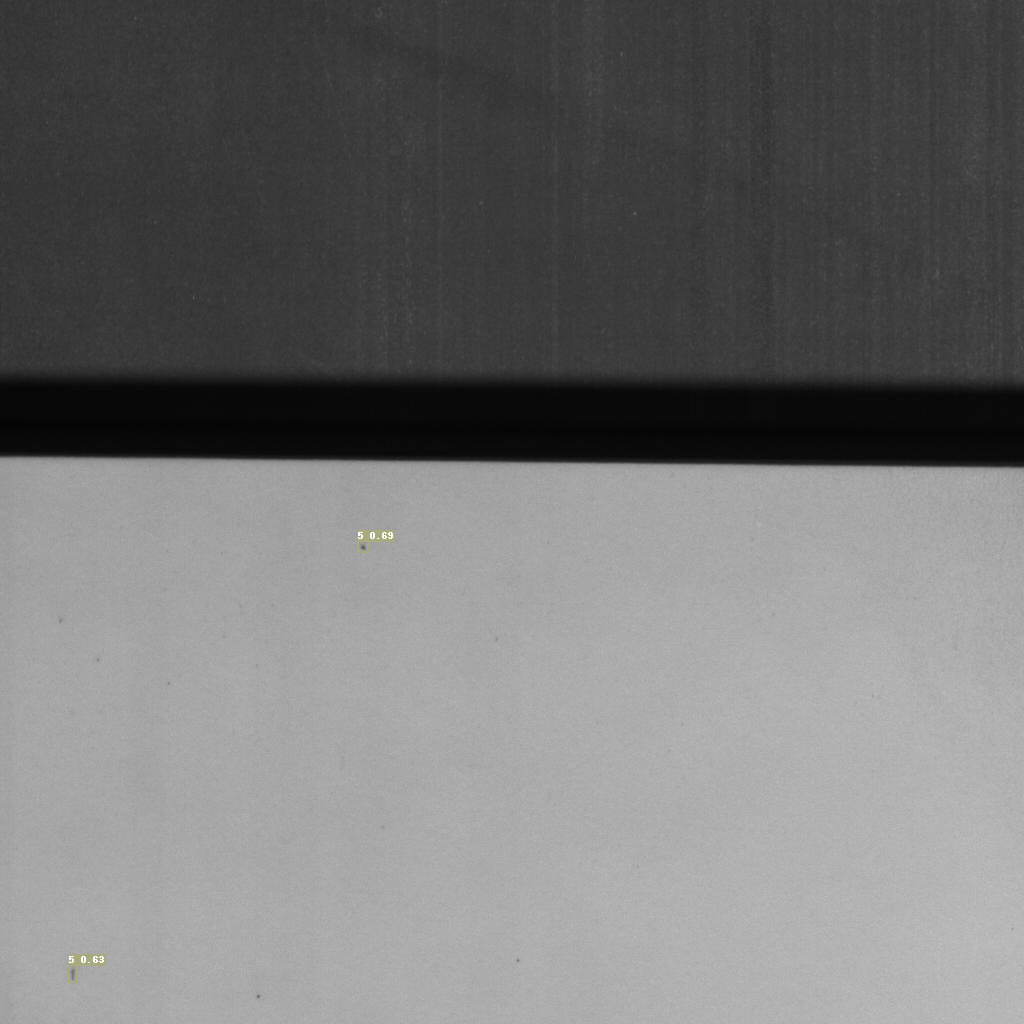

In [35]:
image

In [29]:
im_ids

array([[160],
       [161],
       [162],
       [163],
       [164],
       [165],
       [166],
       [167]], dtype=int64)

In [30]:
im_ids

array([[160],
       [161],
       [162],
       [163],
       [164],
       [165],
       [166],
       [167]], dtype=int64)

In [31]:
res['im_id']

(array([[160],
        [161],
        [162],
        [163],
        [164],
        [165],
        [166],
        [167]], dtype=int64),
 [])